In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [ ]:
!pip install tensorflow

from tensorflow import keras

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/traffic-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 277k/277k [00:00<00:00, 55.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/fedesoriano/traffic-prediction-dataset/versions/1


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

df["Year"] = df['DateTime'].dt.year
df["Month"] = df['DateTime'].dt.month
df["Date_no"] = df['DateTime'].dt.day
df["Hour"] = df['DateTime'].dt.hour
df["Day"] = df['DateTime'].dt.strftime("%A")

df


,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


<Axes: xlabel='Date_no', ylabel='Vehicles'>

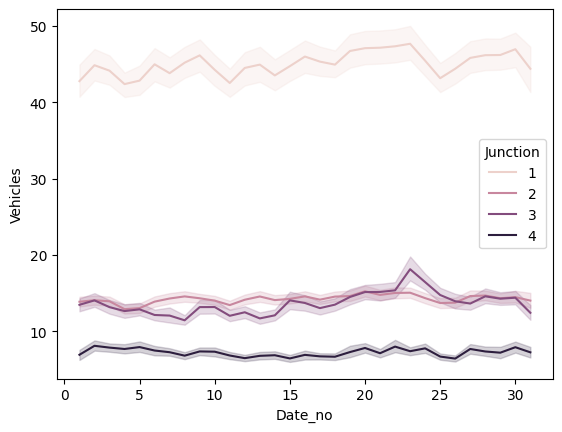

In [ ]:
sns.lineplot(x=df['Date_no'],y="Vehicles",data=df,hue='Junction')

In [ ]:
# Step 1: Filter the DataFrame
df_filtered = df[df['Junction'] == 1]

# Step 2: Define your Normalize function
def Normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()

    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Step 3: Define your Difference function
def Difference(df, col, interval):
    diff = []

    for i in range(interval, len(df)):
        value = df[col].iloc[i] - df[col].il


In [ ]:
# Step 1: Filter the DataFrame
df_filtered = df[df['Junction'] == 1]
# Step 2: Define your Normalize function
def Normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()

    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()

    return df_normalized, average, stdev

# Step 3: Define your Difference function
def Difference(df, col, interval):
    diff = []

    for i in range(interval, len(df)):
        value = df[col].iloc[i] - df[col].iloc[i - interval]
        diff.append(value)

    return diff

In [ ]:
df_N, av,std=Normalize(df,"Vehicles")
Diff= Difference(df_N, col="Vehicles", interval=(24*7))
df_N= df_N[24*7:]
df_N.columns = ['Norm']
df_N["Diff"]=Diff
df= df_N['Diff'].dropna()
df=df.to_frame()
df.head()

<ipython-input-28-21ede8a44b37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N["Diff"]=Diff


,Diff
168,-0.096385
169,0.144578
170,0.048193
171,0.048193
172,0.048193


In [ ]:
df.shape

(47952, 1)

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(data_frame):
    train, test = train_test_split(data_frame, test_size=0.2, shuffle=False)

    train = train.values.reshape(-1, 1)
    test = test.values.reshape(-1, 1)

    return train, test

df_train, df_test = split_data(df)  # Call the function correctly


In [ ]:


# Function to create sequences for X (features) and y (targets)
def TnF(df):
    # Get the length of the dataframe
    end_len = len(df)

    X = []
    y = []

    steps = 32  # Number of steps to look back

    # Iterate through the dataframe to create sequences for X and y
    for i in range(steps, end_len):
        X.append(df[i-steps:i, 0])  # Use previous `steps` rows as features for X
        y.append(df[i, 0])  # Use the current row as the target y

    # Convert lists to numpy arrays
    X, y = np.array(X), np.array(y)

    return X, y

# Function to reshape train and test sets to fit model input shape
def FeatureFixShape(train, test):
    # Reshape the train and test sets to fit the expected input shape of the model
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0], test.shape[1], 1))

    return train, test

# Generate training and test datasets
X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)

# Reshape the features to fit the model input shape
X_train, X_test = FeatureFixShape(X_train, X_test)


In [ ]:



# Function to train MLP model
def train_MLP(X_train, y_train, X_test, y_test):
    # Reshape input data
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)
    # Early stopping callback
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

    # Define the model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))  # Fixed missing `=`
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9  # Fixed incorrect syntax
    )

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Make predictions
    pred_MLP = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, pred_MLP))
    mae = mean_absolute_error(y_test, pred_MLP)

    # Plot loss history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Fixed incorrect bracket
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print results
    print(f"MLP RMSE: {rmse}")
    print(f"MLP MAE: {mae}")

    return pred_MLP


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to train LSTM model
def train_LSTM(X_train, y_train, X_test, y_test):
    # Reshape input data
    X_train = np.squeeze(X_train)
    X_test = np.squeeze(X_test)

    # Early stopping callback
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

    # Define the model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))  # Fixed activation syntax
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))  # Fixed incorrect activation syntax
    model.add(Dropout(0.2))  # Fixed incorrect dropout value
    model.add(Dense(1))

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9
    )

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )

    # Make predictions
    pred_LSTM = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, pred_LSTM))
    mae = mean_absolute_error(y_test, pred_LSTM)

    # Plot loss history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print results
    print(f"LSTM RMSE: {rmse}")
    print(f"LSTM MAE: {mae}")

    return pred_LSTM


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to train GRU model
def train_GRU(X_train, y_train, X_test, y_test):
    # Ensure X_train and X_test have the right dimensions
    if X_train.ndim == 2:
        X_train = np.expand_dims(X_train, axis=-1)
    if X_test.ndim == 2:
        X_test = np.expand_dims(X_test, axis=-1)

    # Early stopping callback
    early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

    # Define the model
    model = Sequential()
    model.add(GRU(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # Fixed activation syntax
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=18000,
        decay_rate=0.9
    )

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=36,
        batch_size=128,
        callbacks=[early_stopping]
    )

    # Make predictions
    pred_GRU = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, pred_GRU))
    mae = mean_absolute_error(y_test, pred_GRU)

    # Plot loss history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Print results
    print(f"GRU RMSE: {rmse}")
    print(f"GRU MAE: {mae}")

    return pred_GRU



In [ ]:


def PredictionsFlat(test, predicted):
    plt.figure(figsize=(12, 5))

    # Plot true values
    plt.plot(test, color='blue', label="True Values", alpha=0.5)

    # Plot predicted values
    plt.plot(predicted, color='red', label="Predicted Values")

    # Adding title and labels
    plt.title("Traffic Prediction vs True Values")
    plt.xlabel("Date/Time")
    plt.ylabel("Number of Vehicles")

    # Show legend
    plt.legend()

    # Show plot
    plt.show()


MLP Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1037 - val_loss: 0.1030
Epoch 2/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0694 - val_loss: 0.1002
Epoch 3/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0673 - val_loss: 0.0970
Epoch 4/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0634 - val_loss: 0.1011
Epoch 5/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0652 - val_loss: 0.0953
Epoch 6/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0600 - val_loss: 0.0960
Epoch 7/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0602 - val_loss: 0.0976
Epoch 8/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0650 - val_loss: 0.0949
Epoch 9/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0686 - val_loss: 0.0942
Epoch 10/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0597 - val_loss: 0.0949
Epoch 11/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0572 - val_loss: 0.0941
Epoch 12/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

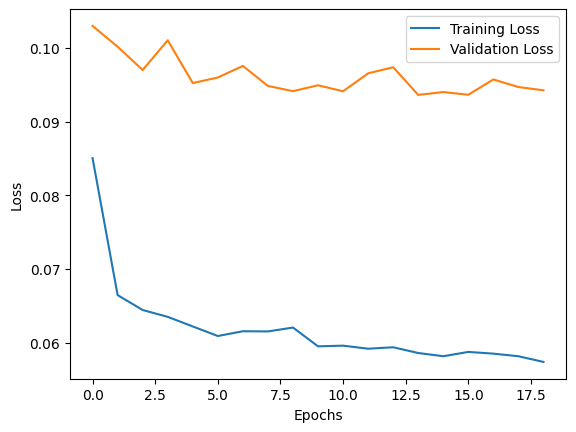

MLP RMSE: 0.30684933770503453
MLP MAE: 0.16789507747159085


In [ ]:
print('MLP Training')
pred_MLP = train_MLP(X_train, y_train, X_test, y_test)

GRU Training


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 0.1029 - val_loss: 0.1062
Epoch 2/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 138ms/step - loss: 0.0638 - val_loss: 0.1030
Epoch 3/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 101ms/step - loss: 0.0621 - val_loss: 0.1028
Epoch 4/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - loss: 0.0624 - val_loss: 0.1012
Epoch 5/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - loss: 0.0621 - val_loss: 0.1012
Epoch 6/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - loss: 0.0597 - val_loss: 0.0993
Epoch 7/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 0.0643 - val_loss: 0.0984
Epoch 8/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - loss: 0.0622 - val_loss: 0.0979
Epoch 9/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - loss: 0.0612 - val_loss: 0.0978
Epoch 10/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - loss: 0.0613 - val_loss: 0.0970
Epoch 11/36
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - loss: 0.0569 - val_loss: 0.0972
Epoch 12/36
300/300 ━━━━━

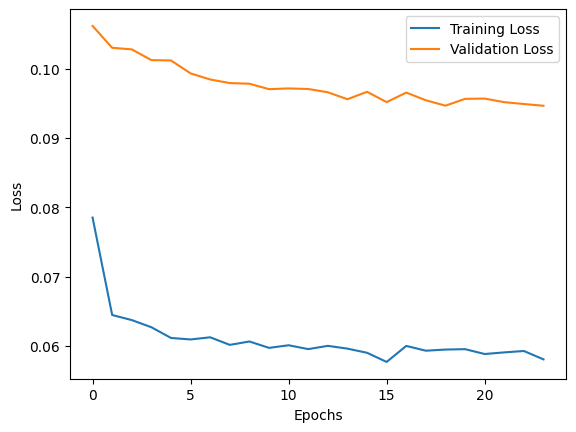

GRU RMSE: 0.30918059411817783
GRU MAE: 0.1695695356241035


In [ ]:
print('GRU Training')
pred_GRU = train_GRU(X_train, y_train, X_test, y_test)

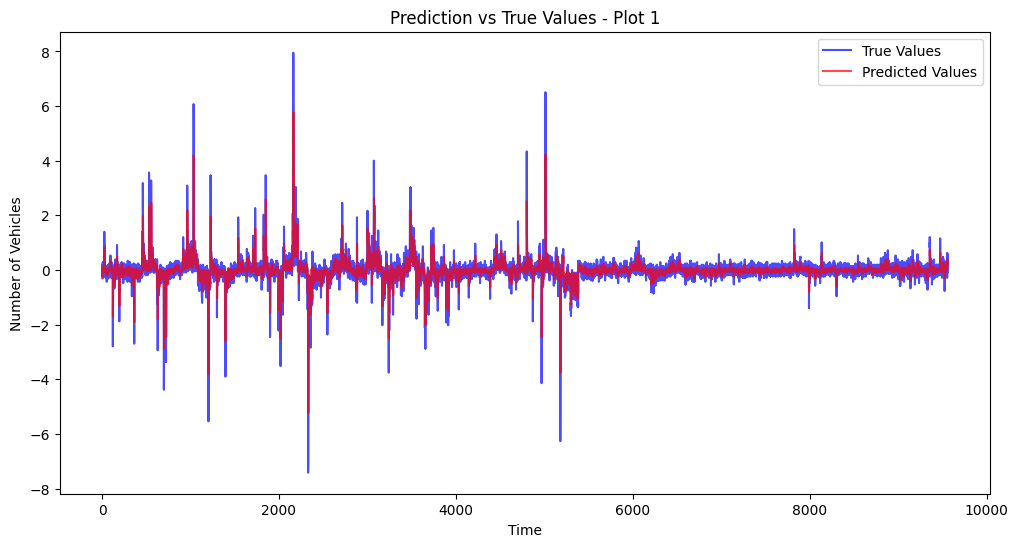

In [ ]:
import matplotlib.pyplot as plt

# Function to plot predictions vs true values
def PredictionsPlot(y_true, y_pred, idx):
    # Ensure the color list has enough colors for the plots
    colors = ['blue', 'red', 'green', 'orange']

    plt.figure(figsize=(12, 6))

    # Plot the true values
    plt.plot(y_true, color=colors[idx % len(colors)], label="True Values", alpha=0.7)

    # Plot the predicted values
    plt.plot(y_pred, color=colors[(idx+1) % len(colors)], label="Predicted Values", alpha=0.7)

    # Adding title and labels
    plt.title(f"Prediction vs True Values - Plot {idx+1}")
    plt.xlabel("Time")  # You can modify this to match your data
    plt.ylabel("Number of Vehicles")  # Modify according to your context

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
PredictionsPlot(y_test, pred_MLP, 0)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.0647 - val_loss: 0.1377
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - loss: 0.0428 - val_loss: 0.1319
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0433 - val_loss: 0.1276
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.0417 - val_loss: 0.1258
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.0414 - val_loss: 0.1224
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - loss: 0.0406 - val_loss: 0.1221
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 0.0412 - val_loss: 0.1199
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.0442 - val_loss: 0.1194
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0405 - val_loss: 0.1206
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - loss: 0.0412 - val_loss: 0.1189
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - loss: 0.0397 - val_loss: 0.1183
Epoch 12/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 

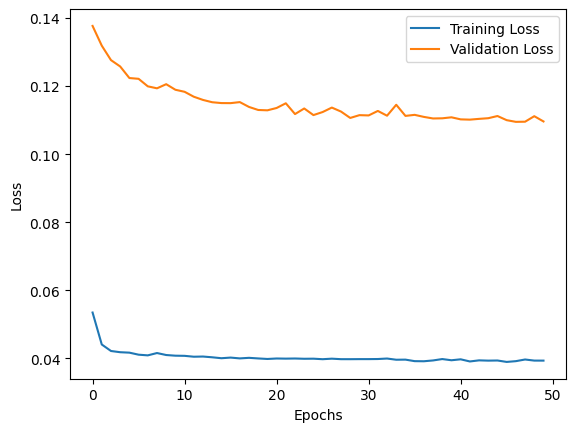

LSTM RMSE: 0.3076062154923409
LSTM MAE: 0.1678116240512769


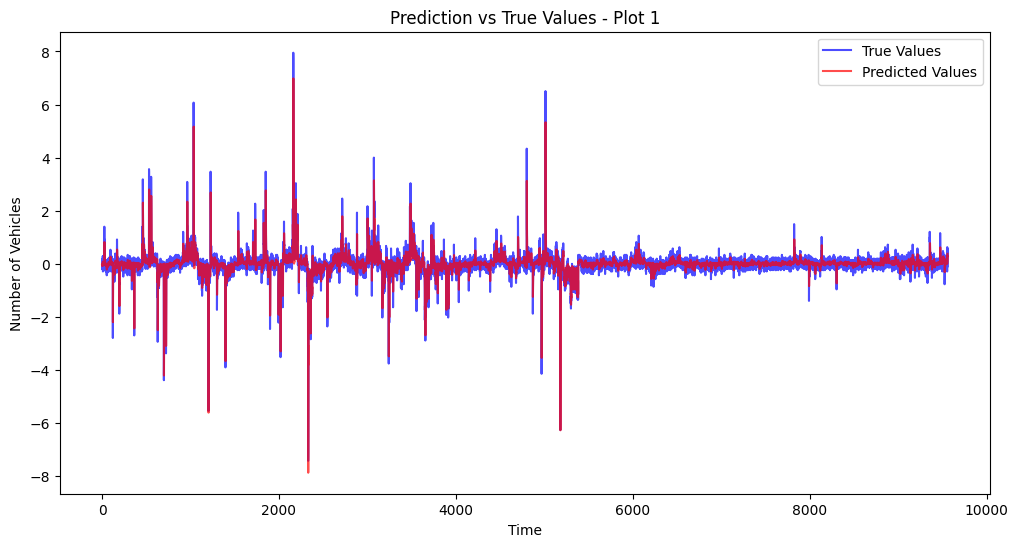

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define LSTM model
def build_lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mean_squared_error')
    return model

# Dummy data example (you should replace this with your actual data)
# Assuming `X_train` and `y_train` are already prepared and preprocessed
# X_train, y_train = ...

# Build the LSTM model
model = build_lstm_model(X_train)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions on test data
pred_LSTM = model.predict(X_test)  # Replace X_test with your test data

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, pred_LSTM))
mae = mean_absolute_error(y_test, pred_LSTM)

# Plot loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"LSTM RMSE: {rmse}")
print(f"LSTM MAE: {mae}")

# Now plot predictions
def PredictionsPlot(y_true, y_pred, idx):
    colors = ['blue', 'red', 'green', 'orange']
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, color=colors[idx % len(colors)], label="True Values", alpha=0.7)
    plt.plot(y_pred, color=colors[(idx + 1) % len(colors)], label="Predicted Values", alpha=0.7)
    plt.title(f"Prediction vs True Values - Plot {idx + 1}")
    plt.xlabel("Time")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

# Call the function to plot true vs predicted values
PredictionsPlot(y_test, pred_LSTM, 0)


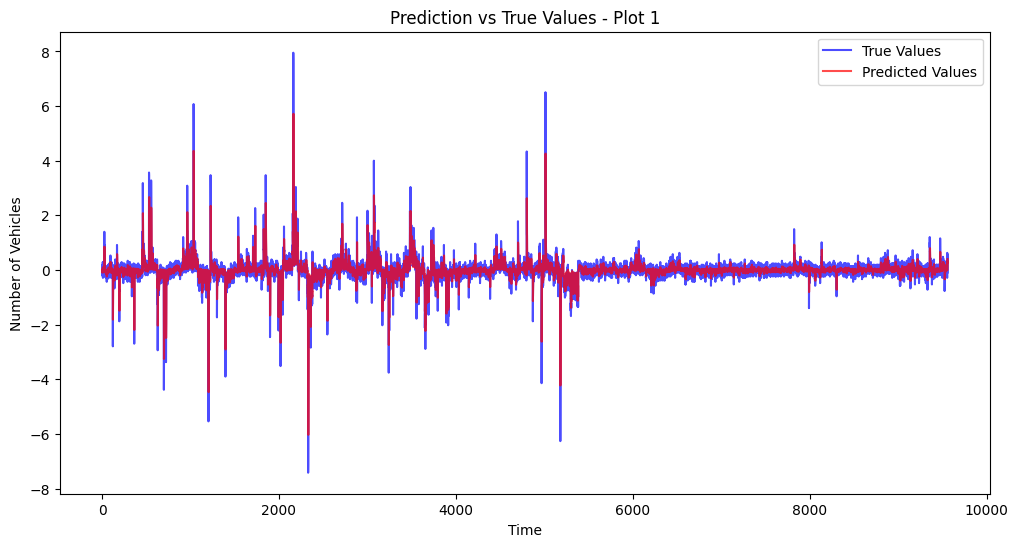

In [ ]:
colors= ['blue', 'red', 'green', 'orange']
PredictionsPlot(y_test, pred_GRU,0)

In [ ]:
#pip install keras-tuner

Trial 2 Complete [00h 31m 50s]
val_loss: 0.09172023832798004

Best val_loss So Far: 0.09172023832798004
Total elapsed time: 01h 01m 17s
Best Hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7b280b86f750>
Epoch 1/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.1256 - val_loss: 0.1235
Epoch 2/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0806 - val_loss: 0.1147
Epoch 3/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - loss: 0.0751 - val_loss: 0.1101
Epoch 4/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - loss: 0.0733 - val_loss: 0.1074
Epoch 5/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - loss: 0.0680 - val_loss: 0.1053
Epoch 6/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.0687 - val_loss: 0.1050
Epoch 7/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 0.0642 - val_loss: 0.1022
Epoch 8/58
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 0.0696 - val_loss: 0.1005
Epoch 9/58
300/300 ━━━━━━━━━━━━━━━

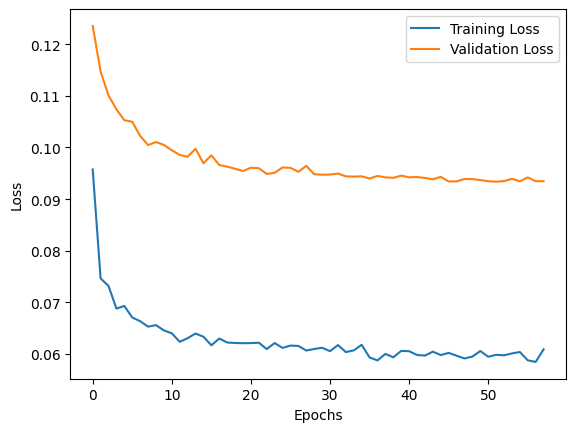

LSTM RMSE: 0.30558424032039183
LSTM MAE: 0.16666004813678087


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define function to build LSTM model
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=200, step=10),
                   activation='relu',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=28, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    lr_schedule = ExponentialDecay(
        initial_learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
        decay_steps=10000,
        decay_rate=0.9,
    )

    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
                  loss='mean_squared_error')
    return model

# Setup Keras Tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=2,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_hyperparameters'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_test, y_test),
             callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters found: {best_hps}")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train,
                         epochs=58,
                         batch_size=128,
                         validation_data=(X_test, y_test),
                         callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate the model
pred_LSTM = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_LSTM))
mae = mean_absolute_error(y_test, pred_LSTM)

# Plot loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"LSTM RMSE: {rmse}")
print(f"LSTM MAE: {mae}")


In [ ]:
if not os.path.exists("folder1"):
  os.makedirs("folder1")

In [ ]:
# Flatten and convert X_train to DataFrame
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))

# Flatten and convert X_test to DataFrame
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))

# Display the new shapes
print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_test_df shape: {X_test_df.shape}")


In [ ]:
# Convert y_train to DataFrame
y_train_df = pd.DataFrame(y_train)

# Convert y_test to DataFrame
y_test_df = pd.DataFrame(y_test)

# Display the new DataFrames
print(f"y_train_df shape: {y_train_df.shape}")
print(f"y_test_df shape: {y_test_df.shape}")


In [ ]:
# Save X_train_df to CSV
X_train_df.to_csv('folder1/X_train.csv', index=False)

# Save y_train_df to CSV
y_train_df.to_csv('folder1/y_train.csv', index=False)

# Save X_test_df to CSV
X_test_df.to_csv('folder1/X_test.csv', index=False)

# Save y_test_df to CSV
y_test_df.to_csv('folder1/y_test.csv', index=False)


In [ ]:
import pickle
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

# Load the model architecture from the JSON file
with open("folder1/model.json", "r") as json_file:
    model_json = json_file.read()

# Load the model from the JSON content
loaded_model = model_from_json(model_json)

# Load the model weights from the file
loaded_model.load_weights("folder1/model_weights.h5")

# Load the best hyperparameters
with open("folder1/best_hyperparameters.pkl", "rb") as file:
    loaded_best_hps = pickle.load(file)

# Compile the model with the saved hyperparameters
loaded_model.compile(
    optimizer=SGD(
        learning_rate=loaded_best_hps['learning_rate'],
        momentum=0.9
    ),
    loss='mean_squared_error'
)

# Print the loaded hyperparameters
print(f"Loaded Hyperparameters: {loaded_best_hps}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Example usage: Make predictions with the loaded model
predictions = loaded_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

# Print evaluation metrics
print(f"LSTM RMSE: {rmse}")
print(f"LSTM MAE: {mae}")


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Function to build LSTM model
def build_lstm_model(hp):
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=1, max_value=260, step=10),
                   activation='relu',
                   input_shape=(X_train.shape[1], X_train.shape[2])))

    # Add Dropout layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Add Dense layers based on hyperparameter tuning
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'dense_units_{i}', min_value=5, max_value=100, step=10),
                        activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])))
        model.add(Dropout(rate=hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add output layer
    model.add(Dense(units=1))

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
        decay_steps=10000,
        decay_rate=0.9
    )

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
                  loss='mean_squared_error')

    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Setup Keras Tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='traffic_dir',
    project_name='lstm_hyperparameters'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=16, restore_best_weights=True)])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters found: {best_hps}")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train, epochs=50, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the model
pred_LSTM = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_LSTM))
mae = mean_absolute_error(y_test, pred_LSTM)

# Plot loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print RMSE and MAE
print(f"LSTM RMSE: {rmse}")
print(f"LSTM MAE: {mae}")
